In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)

import warnings

%matplotlib inline

pd.options.display.max_columns = 80

In [2]:
trips = pd.read_csv('/home/data/fall_2018/HWtrips_032319.csv')

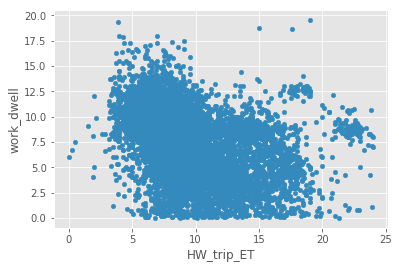

In [3]:
trips.plot.scatter(x='HW_trip_ET',
                   y='work_dwell')

In [4]:
f"Correlation between End Time and Dwell Time: {trips['HW_trip_ET'].corr(trips['work_dwell'])}"

## Given the correlation between HW_trip_ET and work_dwell time
## maybe it makes sense to draw them jointly from a multivariate distribution?

'Correlation between End Time and Dwell Time: -0.4067233807085886'

## "Estimation"

In [5]:
def x_guassian_kde(group, x):
    data = group[[x]].values.T
    return stats.gaussian_kde(data)

def xy_guassian_kde(group, x, y):
    data = group[[x, y]].values.T
    return stats.gaussian_kde(data)


### TOD/HW_trip_ET

In [6]:
# bounds can be manually specified instead
TOD_bounds = (trips.loc[:, ["TOD", "HW_trip_ET"]]
  .groupby("TOD")
  .agg(['min', 'max'])
  #.reset_index(inplace=True)
)
#TOD_bounds.columns = TOD_bounds.columns.map('_'.join).str.strip(" _")
#TOD_bounds = TOD_bounds.rename(columns={"TOD_": "TOD"})
TOD_bounds.columns = ['lower_bound', 'upper_bound']
TOD_bounds

,lower_bound,upper_bound
TOD,,
0,3.166667,5.983333
1,6.000000,8.983333
2,9.000000,15.466667
3,15.500000,18.433333
4,0.016667,24.000000


In [7]:
ET_kde = (trips.loc[:, ["TOD", "HW_trip_ET"]]
          #.query("HW_trip_ET==HW_trip_ET") # filtering for NaN
  .groupby("TOD")
  .apply(lambda g: pd.Series({"kde": x_guassian_kde(g, x="HW_trip_ET")}))        
  #.apply(ST_guassian_kde)
  #.reset_index(name='kde')
)

ET_kde = ET_kde.join(TOD_bounds, on=["TOD"], lsuffix="_x")
#bounds.columns, ST_kde.columns
ET_kde
# Save ST_kde DataFrame for use in simulation


,kde,lower_bound,upper_bound
TOD,,,
0,<scipy.stats.kde.gaussian_kde object at 0x7f86...,3.166667,5.983333
1,<scipy.stats.kde.gaussian_kde object at 0x7f86...,6.000000,8.983333
2,<scipy.stats.kde.gaussian_kde object at 0x7f86...,9.000000,15.466667
3,<scipy.stats.kde.gaussian_kde object at 0x7f86...,15.500000,18.433333
4,<scipy.stats.kde.gaussian_kde object at 0x7f86...,0.016667,24.000000


In [8]:
### work_dwell

In [9]:
# bounds can be manually specified instead
WD_bounds = (trips.loc[:, ["dwell_work", "work_dwell"]]
  .groupby("dwell_work")
  .agg(['min', 'max'])
  #.reset_index(inplace=True)
)
#WD_bounds.columns = WD_bounds.columns.map('_'.join).str.strip(" _")
#WD_bounds = WD_bounds.rename(columns={"TOD_": "TOD"})
WD_bounds.columns = ['lower_bound', 'upper_bound']
WD_bounds

,lower_bound,upper_bound
dwell_work,,
1,0.016667,4.500000
2,4.500000,7.750000
3,7.750000,9.000000
4,9.000000,10.483333
5,10.500000,19.500000


In [10]:
# work_dwell distribution
WD_kde = (trips.loc[:, ["dwell_work", "work_dwell"]]
          #.query("work_dwell==work_dwell") # filtering for NaN
  .groupby("dwell_work")
  .apply(lambda g: pd.Series({"kde": x_guassian_kde(g, x="work_dwell")}))        
  #.apply(ST_guassian_kde)
  #.reset_index(name='kde')
)

WD_kde = WD_kde.join(WD_bounds, on=["dwell_work"], lsuffix="_x")
#bounds.columns, ST_kde.columns
WD_kde
# Save ST_kde DataFrame for use in simulation


,kde,lower_bound,upper_bound
dwell_work,,,
1,<scipy.stats.kde.gaussian_kde object at 0x7f86...,0.016667,4.500000
2,<scipy.stats.kde.gaussian_kde object at 0x7f86...,4.500000,7.750000
3,<scipy.stats.kde.gaussian_kde object at 0x7f86...,7.750000,9.000000
4,<scipy.stats.kde.gaussian_kde object at 0x7f86...,9.000000,10.483333
5,<scipy.stats.kde.gaussian_kde object at 0x7f86...,10.500000,19.500000


## Simulation

In [11]:
a_kde = ET_kde.loc[1, 'kde']
n = 1000
a_min = ET_kde.loc[1, 'lower_bound']
a_max = ET_kde.loc[1, 'upper_bound']

cdf_min, cdf_max = a_kde.integrate_box_1d(-np.inf, a_min), a_kde.integrate_box_1d(-np.inf, a_max)
sample_unif = np.random.uniform(low=cdf_min, high=1.0, size=n)

samples = scipy.stats.mstats.mquantiles(a_kde.dataset[0], sample_unif)
samples.min(), samples.max(), a_min, a_max


(6.0, 8.966666666666667, 6.0, 8.983333333333333)

In [12]:
#from urbansim_templates import modelmanager
#modelmanager.initialize()

#modelmanager.register(m)

#%debug

n_by_TOD = (trips.groupby("TOD")
  .size()
  .reset_index(name='ntrips')
)

n_by_TOD = n_by_TOD.join(ET_kde, on="TOD")

def sample_within_bounds(row):
    a_kde, n = row['kde'], row['ntrips']
    lower_bound, upper_bound = row['lower_bound'], row['upper_bound']
    cdf_min = a_kde.integrate_box_1d(-np.inf, lower_bound)
    cdf_max = a_kde.integrate_box_1d(-np.inf, upper_bound)
    samples_unif = np.random.uniform(low=cdf_min, high=cdf_max, size=n)
    samples = scipy.stats.mstats.mquantiles(a_kde.dataset[0], samples_unif)
    return samples

row = n_by_TOD.loc[1, ]
sample_within_bounds(row)
n_by_TOD['samples'] = n_by_TOD.apply(sample_within_bounds, axis=1)
#n_by_TOD['samples'].apply(min), n_by_TOD['samples'].apply(max)

In [13]:
from sklearn.metrics import r2_score, mean_squared_error

def r2_rmse(g, obs_col, sim_col):
    r2 = r2_score( g[obs_col], g[sim_col] )
    rmse = np.sqrt( mean_squared_error( g[obs_col], g[sim_col] ) )
    return pd.Series( dict(  r2 = r2, rmse = rmse ) )


In [14]:
def sample_within_bounds(row):
    a_kde, n = row['kde'], row['ntrips']
    lower_bound, upper_bound = row['lower_bound'], row['upper_bound']
    cdf_min = a_kde.integrate_box_1d(-np.inf, lower_bound)
    cdf_max = a_kde.integrate_box_1d(-np.inf, upper_bound)
    samples_unif = np.random.uniform(low=cdf_min, high=cdf_max, size=n)
    samples = scipy.stats.mstats.mquantiles(a_kde.dataset[0], samples_unif)
    return samples

def simulate_from_kde(n_by_group, a_kde, group_name, x_name):
    n_by_group = n_by_group.join(a_kde, on=group_name)
    
    n_by_group[x_name] = n_by_group.apply(sample_within_bounds, axis=1)
    
    group_values = n_by_group[group_name].repeat(n_by_group[x_name].str.len()).values
    x_values = np.concatenate(n_by_group[x_name].values)
    #print(group_values.shape, x_values.shape)
    
    samples = pd.DataFrame({group_name: group_values,
                            x_name: x_values,
                          })
            
    return samples


In [15]:
### TOD

In [16]:
n_by_TOD = (trips.groupby("TOD")
  .size()
  .reset_index(name='ntrips')
)

#n_by_TOD.columns, ET_kde.columns
  
trips_sim = simulate_from_kde(n_by_TOD, ET_kde, group_name="TOD", x_name="HW_trip_ET")
#trips_sim.loc[trips_sim.HW_trip_ET > 24, 'HW_trip_ET'] -= 24
#trips_sim.loc[trips_sim["TOD"].isin([14.0, 24.0]) & (trips_sim.WH_trip_ST < 12), 'WH_trip_ST'] -= 24

In [17]:
assert np.alltrue( 
    n_by_TOD == (trips_sim.groupby("TOD")
                 .size()
                 .reset_index(name='ntrips')
                )
)
#trips_sim.columns, bounds.columns

In [18]:
# check for samples out of bounds; should be empty
(
trips_sim.join(TOD_bounds, on="TOD")
    .query('(HW_trip_ET < lower_bound) or ' +
                '(HW_trip_ET > upper_bound)')
)

,TOD,HW_trip_ET,lower_bound,upper_bound


In [19]:
# validation
results = (
trips.sort_values(by="TOD")
    .assign(HW_trip_ET_sim=trips_sim.sort_values(by="TOD").loc[:, "HW_trip_ET"].values)
    .loc[:, ["TOD", "HW_trip_ET", "HW_trip_ET_sim"]]
)    

results.groupby('TOD').apply( r2_rmse, 
                            obs_col = "HW_trip_ET", 
                            sim_col = "HW_trip_ET_sim" ).reset_index()

,TOD,r2,rmse
0,0,-0.960868,0.899741
1,1,-0.917061,1.048679
2,2,-0.996922,2.586998
3,3,-0.885246,1.115309
4,4,-1.110380,7.036270


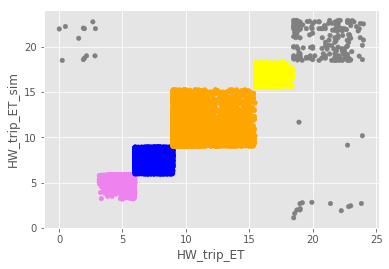

In [20]:
colors = {0:'violet', 1:'blue', 
          2:'orange', 3:'yellow',
          4:'grey', 5: 'black'
         }

results.plot.scatter(x='HW_trip_ET',
                     y='HW_trip_ET_sim',
                     c=results.TOD.apply(lambda x: colors[x]))

### work_dwell

In [21]:
n_by_WD = (trips.groupby("dwell_work")
  .size()
  .reset_index(name='ntrips')
)

#n_by_DT.columns, DT_kde.columns
  
trips_sim = simulate_from_kde(n_by_WD, WD_kde, group_name="dwell_work", x_name="work_dwell")


In [22]:
assert np.alltrue( 
    n_by_WD == (trips_sim.groupby("dwell_work")
                 .size()
                 .reset_index(name='ntrips')
                )
)
#trips_sim.columns, bounds.columns

In [23]:
# check for samples out of bounds; should be empty
(
trips_sim.join(WD_bounds, on="dwell_work")
    .query('(work_dwell < lower_bound) or ' +
                '(work_dwell > upper_bound)')
)

,dwell_work,work_dwell,lower_bound,upper_bound


In [24]:
# validation
results = (
trips.sort_values(by="dwell_work")
    .assign(work_dwell_sim=trips_sim.sort_values(by="dwell_work").loc[:, "work_dwell"].values)
    .loc[:, ["dwell_work", "work_dwell", "work_dwell_sim"]]
)    

results.groupby('dwell_work').apply( r2_rmse, 
                                    obs_col = "work_dwell", 
                                    sim_col = "work_dwell_sim" ).reset_index()

,dwell_work,r2,rmse
0,1,-0.881327,1.749826
1,2,-0.882640,1.297616
2,3,-0.899674,0.448137
3,4,-0.889545,0.567301
4,5,-0.972475,1.767274


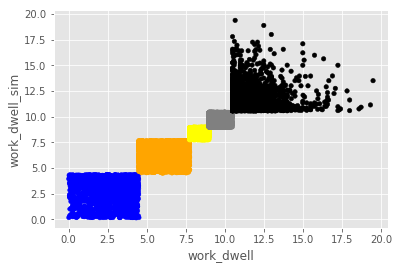

In [25]:
colors = {0:'violet', 1:'blue', 
          2:'orange', 3:'yellow',
          4:'grey', 5: 'black'
         }

results.plot.scatter(x='work_dwell',
                     y='work_dwell_sim',
                     c=results.dwell_work.apply(lambda x: colors[x]))